# Over Current Relay (OC relay)

Pandapower supports running protection scenarios using Definite Time Over Current Relay (DTOC), Inverse Definite Minimum Time (IDMT) and Inverse Definite Time Minimum over current Relay, which is a combination of DTOC and IDMT (IDTOC) in radial and meshed networks. It supports the automated time grading plan based on grid searches and manual time grading.

### Example Network
Here is a little example of creating the over-current protection scenario. First, we create a network with 7 buses and 8 switches. This modelling scheme adds the relay features to the existing switches in the pandapower network. The switch is type defined as 'CB_DTOC' for running protection scenarios using DTOC relay, 'CB_IDMT' for using IDMT relay and 'CB_IDTOC' for using IDTOC relay.


In [1]:
def oc_relay_net():
    import pandapower as pp
    
    # create an empty network
    net = pp.create_empty_network()  
    
    #create buses
    pp.create_buses(net, nr_buses=7, vn_kv=20, index=[0,1,2,3,4,5,6], name=None, type="n", 
                    geodata=[(0,0), (0, -1), (-2, -2), (-2, -4), (2, -2), (2, -3), (2, -4)])

    # create external grids
    pp.create_ext_grid(net, 0, vm_pu=1.0, va_degree=0, s_sc_max_mva=100, s_sc_min_mva=50, rx_max=0.1, rx_min=0.1)
    
    pp.create_lines(net, from_buses=[0,1,2,1,4,5], to_buses=[1,2,3,4,5,6], length_km=[2,5,4,4,0.5,0.5],std_type="NAYY 4x50 SE",
                 name=None, index=[0,1,2,3,4,5], df=1., parallel=1)

    net.line["endtemp_degree"] = 250
    
    # Define switches
    pp.create_switches(net, buses =  [0,1,1,2,4,5], elements =
                       [0,1,3,2,4,5], et = 'l', type ="CB_DTOC")
    #define load
    pp.create_loads(net, buses=[3,6], p_mw=[5,2], q_mvar=[1,1], const_z_percent=0, const_i_percent=0, sn_mva=None,
                     name=None, scaling=1., index=[0,1])

    return net

##  DTOC Relay Protection

Required inputs for oc_parameters:
* 1) net: (pandapowerNet) - Pandapower network with switch type as "CB_DTOC" in the net.switch.type
* 2) relay_type: (string) - 'DTOC'
* 3) time_settings: (list, DataFrame): Relay tripping time is given as a list or a DataFrame 
    if relay tripping time is given as a list, the time grade is calculated based on topological grid search.
        - time_settings =[t>>, t> t_diff],
        - t>>(t_gg): instantaneous tripping time in seconds,
        - t>(t_g):  backup tripping time in seconds, 
        - t_diff: time grading delay difference in seconds
     If given as a Dataframe with columns as 'switch_id', 't_gg', 't_g', user-defined relay trip time will be taken (t_gg and t_g should be provided for all the active switches)
* sc_fraction: (float, 0.95) - Maximum possible extent to which the short circuit can be created on the line

* 4) overload_factor : (float, 1.25)- Allowable overloading on the line used to calculate the pick-up current

* 5) ct_current_factor :(float, 1.2) - Current multiplication factor to calculate the pick-up current

* 6) safety_factor : (float, 1) - Safety limit for the instantaneous pick-up current

Now, we load the network, create oc parameter settings using the oc_parameters function and calculate the short circuit at the selected line and location using the run_fault_scenario_oc function:

In [2]:
net = oc_relay_net()
from pandapower.protection import oc_relay_model as oc_protection

The main function to create relay settings for DTOC relay using oc_parameters

In [3]:
relay_settings_DTOC=oc_protection.oc_parameters(net,time_settings= [0.07, 0.5, 0.3], relay_type='DTOC')

hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers


In [4]:
# show relay_settings
relay_settings_DTOC

,switch_id,line_id,bus_id,relay_type,curve_type,I_g[kA],I_gg[kA],t_g[s],t_gg[s]
0,0,0,0,DTOC,Definite time curve,0.213,2.630156,1.4,0.07
1,1,1,1,DTOC,Definite time curve,0.213,1.849718,1.1,0.07
2,2,3,1,DTOC,Definite time curve,0.213,1.985302,1.1,0.07
3,3,2,2,DTOC,Definite time curve,0.213,1.401313,0.8,0.07
4,4,4,4,DTOC,Definite time curve,0.213,1.887702,0.8,0.07
5,5,5,5,DTOC,Definite time curve,0.213,1.819410,0.5,0.07


Required inputs for running run_fault_scenario_oc:
* 1) net: (pandapowerNet) - Pandapower network with switch type as "CB_non_directional" in the net.switch.type
* 2) sc_line_id (int, index): Index of the line to create the short circuit
* 3) sc_location (float): Location of a short circuit on the line (between 0 and 1).
* 4) relay_settings (Dataframe, float)- relay setting given as a dataframe returned from oc parameters (manual relay settings given as dataframe by respecting the column names)


Create oc protection scheme using the function run_fault_scenario_oc (return dataframe with switch ID, type, trip, short circuit current (Ikss), trip time).

Users can give manual relay settings to the run fault scenario as dataframe in the respective column without using the oc_parameters function

In [5]:

trip_decisions_DTOC,net_sc=oc_protection.run_fault_scenario_oc(net,sc_line_id=4,sc_location =0.5,
                                                               relay_settings=relay_settings_DTOC)

hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers


   Switch ID Switch type      Trip type   Trip  Fault Current [kA]  \
0          0        DTOC         backup   True            1.919548   
1          1        DTOC        no trip  False            0.000000   
2          2        DTOC         backup   True            1.919548   
3          3        DTOC        no trip  False            0.000000   
4          4        DTOC  instantaneous   True            1.919548   
5          5        DTOC        no trip  False            0.000000   

   Trip time [s]  
0           1.40  
1            inf  
2           1.10  
3            inf  
4           0.07  
5            inf  


# Show trip decisions
The function run fault scenario returns a list of dictionaries with tripping decisions of each switch in the network.
- switch index: Index number of the switch 
- switch type: Type of switch in the network (OC- over current switch)
- Trip: Trip is true or false
- Fault current:  Maximum short circuit current at the relay location (minimum short circuit can also be specified, please refer to short circuit in pandapower documentation.
- Igg: Instantaneous tripping current in Ampere (A)
- Ig: Backup tripping current in Ampere (A)
- Trip Type: 
    -Instantaneous trip if fault current >=Igg
    -Backup  fault current >=Ig and less than Igg
    -No trip fault current less than Igg or  Ig
    
- Tripping time: Tripping time of the respective switch
- tg: backup tripping time calculated based on the time grading plan
- tgg: Instantaneous tripping time based on the input tgg

Trip decisions of each switch can be shown by indexing the respective switch id.

In [6]:
# show the trip decision for switch_id=1
trip_decisions_DTOC[1]

{'Switch ID': 1,
 'Switch type': 'DTOC',
 'Trip type': 'no trip',
 'Trip': False,
 'Fault Current [kA]': 0.0,
 'Trip time [s]': inf,
 'Ig': 0.21299999999999997,
 'Igg': 1.8497183168006885,
 'Is': nan,
 'tg': 1.1,
 'tgg': 0.07,
 't_s': nan}

In [7]:
# print short circuit grid net_sc
net_sc

This pandapower network includes the following parameter tables:
   - bus (8 element)
   - load (2 element)
   - switch (6 element)
   - ext_grid (1 elements)
   - line (7 element)
   - bus_geodata (8 element)
 and the following results tables:
   - res_bus_sc (1 elements)
   - res_line_sc (7 element)
   - res_ext_grid_sc (1 elements)
   - res_switch_sc (6 element)

## Show tripped grid
Shows tripped switches, short circuit currents, sc location with respective annotations

hp.pandapower.plotting.collections - WARNING: use_bus_geodata is automatically set to True, since net.line_geodata is empty.
hp.pandapower.plotting.plotting_toolbox - INFO: Interpreting color (0.00392156862745098, 0.45098039215686275, 0.6980392156862745) as rgb or rgba!


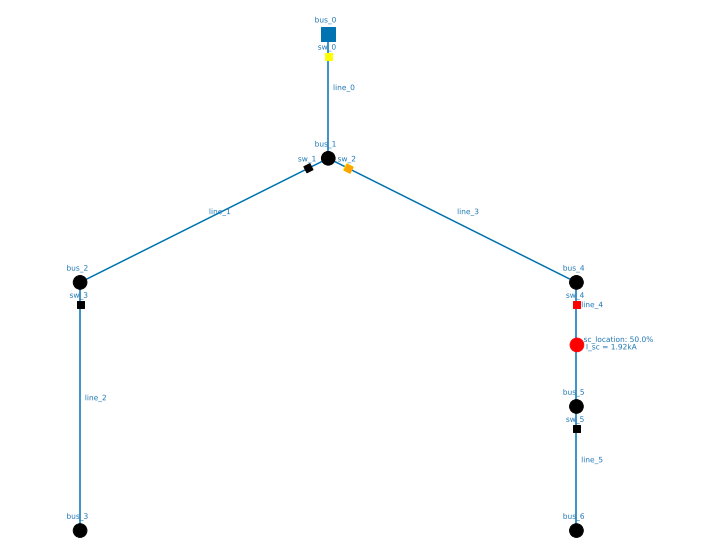

In [8]:
from pandapower.protection.utility_functions import plot_tripped_grid
plot_tripped_grid(net_sc, trip_decisions_DTOC,sc_location=0.5,plot_annotations=True)

# Create I-t Plot
Plot showing the relation between current and time by using trip decisions and switch index using function create_I_t_plot from the utility function


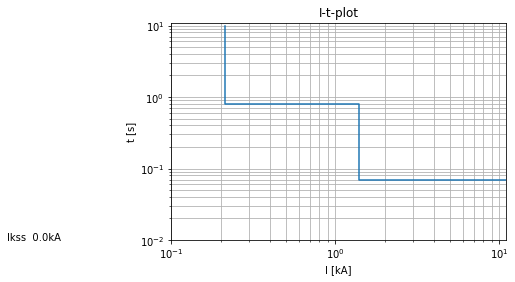

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [9]:
from pandapower.protection.utility_functions import create_I_t_plot
import matplotlib.pyplot as plt
create_I_t_plot(trip_decisions_DTOC,switch_id=[3])
plt.close()

# Additional features of DTOC

### Manual tripping time for each switches
Manual tripping time can be given as dataframe with columns as 'switch_id', 't_gg', 't_g'


In [10]:
import pandas as pd
tripping_time= pd.DataFrame({'switch_id': [0,1,2,3,4,5],
                          't_gg': [0.07,0.07,0.07,0.07,0.07,0.07],
                          't_g':[0.5,0.8,1.1,1.4,1.7,2.0]})
relay_settings=oc_protection.oc_parameters(net,time_settings= tripping_time, relay_type='DTOC')
trip_decisions,net_sc=oc_protection.run_fault_scenario_oc(net,sc_line_id=4,sc_location =0.5,relay_settings=relay_settings)

hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers


   Switch ID Switch type      Trip type   Trip  Fault Current [kA]  \
0          0        DTOC         backup   True            1.919548   
1          1        DTOC        no trip  False            0.000000   
2          2        DTOC         backup   True            1.919548   
3          3        DTOC        no trip  False            0.000000   
4          4        DTOC  instantaneous   True            1.919548   
5          5        DTOC        no trip  False            0.000000   

   Trip time [s]  
0           0.50  
1            inf  
2           1.10  
3            inf  
4           0.07  
5            inf  


### Varying OC parameters
OC fault scenario is capable of changing the pick-up current for each switch by varying the default values in the following parameters from the default value:

- sc_fraction (float, 0.95): Maximum possible extent to which the short circuit can be created on the line.
- overload_factor (float, 1.25): Allowable over loading on the line used to calculate the pick-up current.
- ct_current_factor (float, 1.2): Current transformer multiplication factor to define the pick-up current.
- safety_factor (float, 1): Safety limit for the instantaneous pick-up currents.

In [14]:
#create relay settings
relay_settings=oc_protection.oc_parameters(net,sc_fraction=0.9, overload_factor=1.5, ct_current_factor=2,safety_factor=1.5,
                                           time_settings= tripping_time, relay_type='DTOC')
#get trip decisions
trip_decisions,net_sc=oc_protection.run_fault_scenario_oc(net,sc_line_id=4,sc_location =0.5,relay_settings=relay_settings)

hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers


   Switch ID Switch type Trip type   Trip  Fault Current [kA]  Trip time [s]
0          0        DTOC    backup   True            1.919548            0.5
1          1        DTOC   no trip  False            0.000000            inf
2          2        DTOC    backup   True            1.919548            1.1
3          3        DTOC   no trip  False            0.000000            inf
4          4        DTOC    backup   True            1.919548            1.7
5          5        DTOC   no trip  False            0.000000            inf


### Manual tripping current for each switches
Instead of varying the OC parameters, users can define pickup current (instantaneous and backup) 
for each switch in the form of a dataframe.

In [15]:
pickup_current_manual= pd.DataFrame({'switch_id': [0,1,2,3,4,5],
                              'I_gg': [2.2,2.3,2.1,2.5,1.2,0.9],
                              'I_g':[0.8,0.7,0.7,0.8,0.8,0.8]})
relay_settings=oc_protection.oc_parameters(net,time_settings= [0.07, 0.5, 0.3],pickup_current_manual=pickup_current_manual,
                                           relay_type='DTOC')

trip_decisions,net_sc=oc_protection.run_fault_scenario_oc(net,sc_line_id=4,sc_location =0.5,relay_settings=relay_settings)

hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers


   Switch ID Switch type      Trip type   Trip  Fault Current [kA]  \
0          0        DTOC         backup   True            1.919548   
1          1        DTOC        no trip  False            0.000000   
2          2        DTOC         backup   True            1.919548   
3          3        DTOC        no trip  False            0.000000   
4          4        DTOC  instantaneous   True            1.919548   
5          5        DTOC        no trip  False            0.000000   

   Trip time [s]  
0           1.40  
1            inf  
2           1.10  
3            inf  
4           0.07  
5            inf  


##  IDMT Relay Protection

Required inputs:
* 1) net: (pandapowerNet) - Pandapower network with switch type as "CB_IDMT" in the net.switch.type
* 2) relay_type: (string) - 'IDMT'
* 3) time_settings: (list, DataFrame) - Relay tripping time is given as a list or a DataFrame 
    if relay tripping time is given as a list, the time grade is calculated based on a topological grid search.
        - time_settings =[tms,t_grade]
        - tms: time multiplier setting in seconds,
        - t_grade: time grading delay difference in seconds
     If given as a Dataframe with columns as 'switch_id', 'tms', 't_grade', user-defined relay trip time will be taken (tms and t_grade should be provided for all the active switches)
* 4) inverse_overload_factor:(float, 1.25) - Allowable inverse overloading to define the pickup current in the IDMT relay
* 5) curve_type ('string'): Relay trip time will vary depending on the curve slope for inverse Time Relays. The curves can be used to coordinate with other protective devices for selectivity (according to IEC60255) 

    Curve type can be :
    - 'standard_inverse'
    - 'very_inverse',
    - 'extremely_inverse',
    - 'long_inverse',
    
Now, we load the network, create IDMT relay settings using the oc_parameters function and run the IDMT protection scenario at selected line and location using the run_fault_scenario_oc function:

In [16]:
# Change the switch type in the network

net=oc_relay_net()
net.switch.type='CB_IDMT'

In [17]:

relay_settings_IDMT=oc_protection.oc_parameters(net,time_settings= [1,0.5], relay_type='IDMT', curve_type='standard_inverse')

hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers


In [18]:
# show relay settings
relay_settings_IDMT

,switch_id,line_id,bus_id,relay_type,curve_type,I_s[kA],tms[s],k,t_grade[s],alpha
0,0,0,0,IDMT,standard_inverse,0.1704,1,0.14,2.0,0.02
1,1,1,1,IDMT,standard_inverse,0.1704,1,0.14,1.5,0.02
2,2,3,1,IDMT,standard_inverse,0.1704,1,0.14,1.5,0.02
3,3,2,2,IDMT,standard_inverse,0.1704,1,0.14,1.0,0.02
4,4,4,4,IDMT,standard_inverse,0.1704,1,0.14,1.0,0.02
5,5,5,5,IDMT,standard_inverse,0.1704,1,0.14,0.5,0.02


Relay settings 
- I_s[kA] : Pickup current based on inverse overload factor

- k & alpha: Constants based on the curve type according to IEC60255

- t_grade: Time gradig calculated based on topologocal searches and given t_grade input

In [19]:
# create fault scenario using the relay setting, line and location
trip_decisions_IDMT,net_sc=oc_protection.run_fault_scenario_oc(net,sc_line_id=4,sc_location =0.5,relay_settings=relay_settings)

hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers


   Switch ID Switch type      Trip type   Trip  Fault Current [kA]  \
0          0        DTOC         backup   True            1.919548   
1          1        DTOC        no trip  False            0.000000   
2          2        DTOC         backup   True            1.919548   
3          3        DTOC        no trip  False            0.000000   
4          4        DTOC  instantaneous   True            1.919548   
5          5        DTOC        no trip  False            0.000000   

   Trip time [s]  
0           1.40  
1            inf  
2           1.10  
3            inf  
4           0.07  
5            inf  


# Show trip decisions
The function run fault scenario returns a list of dictionaries with tripping decisions of each switch in the network.
- Fault current: Maximum short circuit current at the relay location 
- Is: Inverse tripping current in Ampere (kA)
- Trip Type: 
    -Instantaneous trip if the fault current >=I_s
    -No trip fault current less than I_s
    
- Tripping time - ts: Tripping time of the respective switch (based on the fault current i_ks)

    ts=(tms*k)/(i_ka/I_s)^alpha)-1))+t_grade

Tripping decisions of each switch can be shown by indexing the respective switch id

In [20]:
trip_decisions_IDMT[1]

{'Switch ID': 1,
 'Switch type': 'DTOC',
 'Trip type': 'no trip',
 'Trip': False,
 'Fault Current [kA]': 0.0,
 'Trip time [s]': inf,
 'Ig': 0.7,
 'Igg': 2.3,
 'Is': nan,
 'tg': 1.1,
 'tgg': 0.07,
 't_s': nan}

# Additional features of IDMT

### Manual tripping time for each switches
Manual tripping time can be given as a dataframe with columns as 'switch_id', 'tms', 't_grade.'

In [21]:
tripping_time= pd.DataFrame({'switch_id': [0,1,2,3,4,5],
                          'tms': [0.07,0.07,0.07,0.07,0.07,0.07],
                          't_grade':[0.5,0.8,1.1,1.4,1.7,2.0]})
relay_settings=oc_protection.oc_parameters(net,time_settings= tripping_time, relay_type='IDMT', curve_type='standard_inverse')
trip_decisions,net_sc=oc_protection.run_fault_scenario_oc(net,sc_line_id=4,sc_location =0.5,relay_settings=relay_settings)

hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers


   Switch ID Switch type      Trip type   Trip  Fault Current [kA]  \
0          0        IDMT  instantaneous   True            1.919548   
1          1        IDMT        no trip  False            0.000000   
2          2        IDMT  instantaneous   True            1.919548   
3          3        IDMT        no trip  False            0.000000   
4          4        IDMT  instantaneous   True            1.919548   
5          5        IDMT        no trip  False            0.000000   

   Trip time [s]  
0       0.524282  
1            inf  
2       1.124282  
3            inf  
4       1.724282  
5            inf  


### Varying OC parameters
oc parameters are capable to set pick-up tripping current for each switch by varying the default values in the following parameters from the default value:

* inverse_overload_factor (float, 1.2) Allowable inverse overloading on the line used to calculate the pick-up current.

In [22]:
relay_settings_IDMT=oc_protection.oc_parameters(net,inverse_overload_factor=2.1,time_settings= [1,0.5], relay_type='IDMT',
                                                curve_type='standard_inverse')

hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers


All the additional features and plotting functions are possible for IDMT relay (similar to DTOC)

##  IDTOC Relay Protection

Required inputs for the oc_parameters:
* 1) net: (pandapowerNet) - Pandapower network with switch type as "CB_IDTOC" in net.switch.type
* 2) relay_type: (string) - 'IDTOC'
* 3) time_settings: (list, DataFrame): Relay tripping time can be given as list or a DataFrame 
    if relay tripping time is given as a list, the time grade is calculated based on a topological grid search.
        - time_settings =[t>>, t> t_diff, tms, t_grade],
        - t>>(t_gg): instantaneous tripping time in seconds,
        - t>(t_g):  backup tripping time in seconds, 
        - t_diff: time grading delay difference in seconds
        - tms: time multiplier setting in seconds,
        - t_grade: time grading delay difference in seconds
     If given as a Dataframe with columns as 'switch_id', 't_gg', 't_g', 'tms', 't_grade' user defined relay trip time will be taken (t_gg and t_g should be provided for all the active switches)
* sc_fraction: (float, 0.95) - Maximum possible extent to which the short circuit can be created on the line

* 4) overload_factor : (float, 1.25)- Allowable overloading on the line used to calculate the pickup current

* 5) ct_current_factor :(float, 1.2) - Current multiplication factor to calculate the pick-up current

* 6) safety_factor : (float, 1) - Safety limit for the instantaneous pickup current

* 7) inverse_overload_factor:(float, 1.25) - Allowable inverse overloading to define the pickup current in IDMT relay

* 8) curve_type ('string'): Relay trip time will vary depending on the curve slope for inverse time relays. The curves is used to coordinate with other protective devices for selectivity (according to IEC60255) 

    Curve type can be :
    - 'standard_inverse'
    - 'very_inverse',
    - 'extremely_inverse',
    - 'long_inverse',

Now, we load the network, create parameter settings using oc_parameters function and calculate the short circuit at the selected line and location using the run_fault_scenario_oc function. Depending on the current pickup values IDTOC relay shows DTOC or IDMT behaviour

In [23]:
# Change the switch type in the network

net=oc_relay_net()
net.switch.type='CB_IDTOC'

In [24]:

relay_settings_IDTOC=oc_protection.oc_parameters(net,time_settings= [0.07,0.5,0.3, 1,0.5], relay_type='IDTOC',
                                                 curve_type='standard_inverse')

hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers
hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers


In [25]:
# create fault scenario using the relay setting, line and location
trip_decisions_IDTOC,net_sc=oc_protection.run_fault_scenario_oc(net,sc_line_id=4,sc_location =0.5,relay_settings=relay_settings)

hp.pandapower.shortcircuit.calc_sc - WARNING: Branch results are in beta mode and might not always be reliable, especially for transformers


   Switch ID Switch type      Trip type   Trip  Fault Current [kA]  \
0          0        IDMT  instantaneous   True            1.919548   
1          1        IDMT        no trip  False            0.000000   
2          2        IDMT  instantaneous   True            1.919548   
3          3        IDMT        no trip  False            0.000000   
4          4        IDMT  instantaneous   True            1.919548   
5          5        IDMT        no trip  False            0.000000   

   Trip time [s]  
0       0.524282  
1            inf  
2       1.124282  
3            inf  
4       1.724282  
5            inf  


##  All the additional features which are previously described will also function for IDTOC relay

